# ReACT

For the following example you need the Pyhton wrapper for CAMB installed. The easiest way to do this is to use the `conda` package:

`conda install camb -c conda-forge`

In [28]:
import numpy as np
import camb

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact

Set the cosmology and let CAMB compute the linear power spectrum.

In [29]:
Omega_m = 0.3089
Omega_b = 0.0486
Omega_c = Omega_m-Omega_b
h = 0.6774
n_s = 0.9667
A_s = 2.064e-9
m_nu = 0.0
w0 = -1.0
w_a = 0.0


# Model selection and parameters 
mymodelA = "kmouflage"
n=2
lam=1.4518
K0=1
beta0=0.1

massloop = 50

extrapars = np.zeros(20)
extrapars[0] = n;
extrapars[1] = lam;
extrapars[2] = K0;
extrapars[3] = beta0;

p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False, DarkEnergyModel="fluid")
    
p.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))
p.set_dark_energy(w=w0,wa=w_a)

p.set_matter_power(redshifts=np.linspace(0.0, 10.0, 64, endpoint=True)[::-1],
                   kmax=10.0, nonlinear=False)

r = camb.get_results(p)
sigma_8 = r.get_sigma8()[-1]
k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=128)

Omega_v = r.omega_de + r.get_Omega("photon") + r.get_Omega("neutrino")
Omega_m = p.omegam

Now run ReACT to get the reaction and the modified gravity linear power spectrum that will get used by HMCode.

In [30]:
react = pyreact.ReACT()

# Only compute the reaction up to z=2.5
z_lin = np.array(z_lin)
z_react = z_lin[z_lin < 2.5]


R, pofk_lin_MG_react, sigma_8_MG, pseudo = react.compute_reaction_ext(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], mymodelA, 
                                extrapars, 
                                compute_pseudo=True,
                                is_transfer=False, mass_loop=massloop,
                                verbose=True) 

Now make some plots!

Text(0.5, 1.0, 'z = 0, n = 2.0, lambda = 1.4518, K0= 1.0, betaK= 0.1')

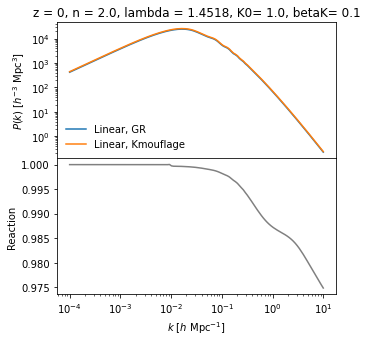

In [31]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].loglog(k_lin, pofk_lin_camb[0], label="Linear, GR")
ax[0].loglog(k_lin, pofk_lin_MG_react[0], label="Linear, Kmouflage")

ax[1].plot(k_lin, R[0], color='grey')

ax[0].legend(frameon=False)

ax[0].set_ylabel("$P(k)$ [$h^{-3}$ Mpc$^3$]")
ax[1].set_ylabel("Reaction")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title(f"z = 0, n = {extrapars[0]}, lambda = {extrapars[1]}, K0= {extrapars[2]}, betaK= {extrapars[3]}")
